In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tarfile
import os
import requests
import random
from tqdm import tqdm
from collections import namedtuple
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
from IPython.utils.io import capture_output
#InteractiveShell.ast_node_interactivity = "all"

In [3]:
np.random.seed(400)
random.seed(400)

# Intro
Simple notebook showing the steps to implement a NN from scratch. This notebook consists of two big parts, implementing one-layer nn and then extending it to k-layers nn. For this notebook, we are going to implement a k linear layer neural network with relu as activation. Unfortunately, since deeper layers requires batch norm for stability, and I don't think I have the time to implement batch norm for now, we will only be initializing 2-layers on the neural net, although it has the capacility for k-layers. The task is image classification on cifar10 dataset, and the hope is to get a performance better than random guessing which given the 10 classes, should be $> 1/10$. This would indicate that it at least learnt something.

# Purpose 
There are lots of tutorials online, that are better than this notebook I'm constructing, like Karpathy's famous [micrograd series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ), but I wanted to take a more **analytical approach** as per my previous labs in a DL course I took years ago, showing how to go from a computational graph to deriving the math for the gradients to implementing them in a backprop. The hope is to show that this is a very mechanical process, aside from deriving some of the tricky gradients, there's a very clear pattern on how to work with this. What I had in mind should algorithmitcally be very straightforward, however the math for some of the gradients aren't trivial, and sometimes requires drawing the matrices to understand what's really happening. That's the only part I didn't find a simpler way to deal with, which I disliked, although I do think there are easier ways to work with them, something something about proper matrix calculus techniques. Admittedly, Karpathy's video is easier to understand and shorter code, since it's an implementation of automatic differentiation, whereas this implementation is purely analytical and not automatic. Regardless, it can serve as an alternative approach, to give a different perspective as it doesn't require implementing an automatic differentiation engine.

# Prerequisites
Basics of chain rule and familiarity with matrix calculus and working with matrices in general.

# Preprocess data
Originally 10000 x 32 x 32 x 3, but need to transpose it to get the same shape as in the formulas for the gradients in the derivations. There are 5 files + 1 test file and each file has 10k images. The test file has 10k as well.

* We will extract the first 10k for training and next 10k for validation. Also need to be in $d \times n$ shape, where d is the features and n the number of samples. The test data will be from the test_batch file.
* Labels should be one-hot encoding and in shape $c \times n$, where c is the classes and n the number of samples.
* Need to normalize data, subtract all data by training mean and divide by training std to turn it into zero mean unit variance data. This seems to be a [common practise](https://stats.stackexchange.com/a/202290), since the nn will be trained on the training data and therefore use those statistics. To make those statistics compatible we therefore need to transform the validation and test data the same way.

### Check where current folder is
We should access the cifar-10-python-tar.gz file in the data folder and extract it in the same folder. Adjust the paths accordingly if they are not correct. If the current folder path is chapter6, then it's correct.

In [4]:
current_path = os.getcwd()
print("Current folder path:", current_path) 

Current folder path: e:\training\TWIML-DL-Study-Group\chapter6


In [4]:
DATA_PATH = os.path.join("data")
CIFAR_ROOT_PATH = os.path.join(DATA_PATH, "cifar-10-batches-py")
TEST_DATA_BATCH_PATH = os.path.join(CIFAR_ROOT_PATH, "test_batch")
CIFAR_TAR_PATH = os.path.join(DATA_PATH, "cifar-10-python.tar.gz")

In [5]:
# Download cifar10, might take some time depending on internet speed, can take anywhere from few secs to a few minutes. Took me around 2mins.
if not os.path.exists(CIFAR_TAR_PATH):
    try:
        with requests.get("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", stream=True, timeout=300) as response:
            response.raise_for_status()  # Raise an error for bad status codes
            with open(CIFAR_TAR_PATH, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    with capture_output():
                        file.write(chunk)
        print("Download completed successfully.")
    except requests.exceptions.Timeout:
        print("The request timed out.")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        
if not os.path.exists(CIFAR_ROOT_PATH):
    with tarfile.open(CIFAR_TAR_PATH) as tar:
        tar.extractall(path=DATA_PATH)

In [6]:
# utils for preprocessing data

Data = namedtuple('Data', 'x y')

def load_data(file_path):
    with open(file_path, 'rb') as file:
        dict = pickle.load(file, encoding='bytes')
    return dict[b'data'], dict[b'labels']

def load_cifar10(number_of_batches):
    assert 0 < number_of_batches < 6
    data = []
    labels = []
    test_data, test_labels = load_data(TEST_DATA_BATCH_PATH)
    for i in range(1, number_of_batches + 1):
        d, l = load_data(os.path.join(CIFAR_ROOT_PATH, f"data_batch_{i}"))
        data.append(d)
        labels.append(l)
    # in data rows are samples so stack them on the rows with vstack
    # in labels columns are samples so stack them on the columns with hstack
    return np.vstack(data), np.hstack(labels), np.array(test_data), np.array(test_labels)

def train_valid_split(data, labels, split_ratio):
    assert type(split_ratio) is list and len(split_ratio) == 2 
    x_train, x_valid, y_train, y_valid = train_test_split(data, labels, train_size=split_ratio[0], test_size=split_ratio[1], shuffle=False)
    return x_train, y_train, x_valid, y_valid
    
def transform_data(x_train, x_valid, x_test, y_train, y_valid, y_test):
    # normalize data
    mean = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    x_train = (x_train - mean) / std
    x_valid = (x_valid - mean) / std
    x_test = (x_test - mean) / std
    assert np.allclose(np.mean(x_train, axis=0), np.zeros(x_train.shape[1]))
    assert np.allclose(np.std(x_train, axis=0), np.ones(x_train.shape[1]))
    
    # transform data to d x n to adhere to the gradient formulas
    x_train = x_train.T
    x_valid = x_valid.T
    x_test = x_test.T
    
    # transform labels to one-hot encoding
    y_train_one_hot = np.zeros((10, y_train.size))
    y_train_one_hot[y_train, np.arange(y_train.size)] = 1
    y_valid_one_hot = np.zeros((10, y_valid.size))
    y_valid_one_hot[y_valid, np.arange(y_valid.size)] = 1
    y_test_one_hot = np.zeros((10, y_test.size))
    y_test_one_hot[y_test, np.arange(y_test.size)] = 1
    
    return Data(x_train, y_train_one_hot), Data(x_valid, y_valid_one_hot), Data(x_test, y_test_one_hot)


In [7]:
# Only load the first 20k data, first 10k is for training and other 10k is valid, test batch is a separate data with 10k
# data is wrapped in a Data namedtuple with field x for the data and y for the labels
number_of_batches = 2
x_data, y_data, x_test, y_test =  load_cifar10(number_of_batches)
assert x_data.shape == (number_of_batches * 10000, 3072)
assert y_data.shape == (number_of_batches * 10000,)
assert x_test.shape == (10000, 3072)
assert y_test.shape == (10000,)

# note that the split may not be even due to rounding so the assertions may give false, therefore try to use ratios
# that give even splits or comment out the assertions
train_ratio = 0.5
valid_ratio = 0.5
x_train, y_train, x_valid, y_valid = train_valid_split(x_data, y_data, [train_ratio, valid_ratio])
""" assert x_train.shape == (number_of_batches * 10000 * train_ratio, 3072)
assert x_valid.shape == (number_of_batches * 10000 * valid_ratio, 3072)
assert y_train.shape == (10000,)
assert y_valid.shape == (10000,) """

train, valid, test = transform_data(x_train, x_valid, x_test, y_train, y_valid, y_test)
train.x.shape
""" assert train.x.shape == (3072, number_of_batches * 10000 * train_ratio)
assert valid.x.shape == (3072, number_of_batches * 10000 * valid_ratio)
assert test.x.shape == (3072, 10000)
assert train.y.shape == (10, number_of_batches * 10000 * train_ratio)
assert valid.y.shape == (10, number_of_batches * 10000 * valid_ratio)
assert test.y.shape == (10, 10000) """

' assert train.x.shape == (3072, number_of_batches * 10000 * train_ratio)\nassert valid.x.shape == (3072, number_of_batches * 10000 * valid_ratio)\nassert test.x.shape == (3072, 10000)\nassert train.y.shape == (10, number_of_batches * 10000 * train_ratio)\nassert valid.y.shape == (10, number_of_batches * 10000 * valid_ratio)\nassert test.y.shape == (10, 10000) '

# Deriving the gradients for the NN

We will start with a two-layer nn and extend it to k-layer nn. This is because the gradient of the k-layer nn is almost the same as two-layer except that it will need a loop to continuously update the layers, although using the same formulas as a two-layer nn. **Once again, note that we will consider a single data point and then extend to batches of data.** The computational graph we have for this 2-layer network is illustrated below:

![](./assets/two_layer_nn_comp_graph.png)

where $J$ is the cost function, which takes the output from the final layer to compute the loss. Our functions are thus

$$J = l + \lambda r$$

$$r = \|w_1\|^2 + \|w_2\|$$

$$l = -\log(y^T p)$$

$$p = \operatorname{softmax}(s_2)$$

$$s_2 = w_2h + b_2$$

$$h = \max(0, s_1)$$

$$s_1 = w_1x + b_1$$

**Dimensions.** Note that 
* $y$ is a one-hot encoding, consisting of zeros except for one element that is 1, of size $c \times 1$ for a single data point and $c \times n$ for a dataset of size n. c stands for number of classes, in cifar10 that's 10 classes.
* $w_1$ is $m \times d$, where d is the number of features of the data and k the features of the matrix.
* $x$ is $d \times 1$ for single data point and $d \times n$ for a batch of size n.
* $s_1$ is $m \times 1$ and $m \times n$.
* $h$ is $m \times 1$ and $m \times n$.
* $s_2$ is $c \times 1$ and $c \times n$.
* $p$ is $c \times 1$ and $c \times n$ for a batch.
* $l$ and $J$ both are scalars because they are loss functions.
* $r$ is a scalar, because it's the frobenius norm (l2-norm) of the matrix $w_1$ and $w_2$.

We want to find the optimal parameters for the one linear layer neural network. This nn has $w_1$, $b_1$, $w_2$, $b_2$ as model parameters, so these are the gradients we are looking for

$$\frac{\partial J}{\partial w_1},\  \frac{\partial J}{\partial w_2},\  \frac{\partial J}{\partial b_1},\  \frac{\partial J}{\partial b_2}$$

Following the computational graph, the backprop starts from the end and propagates to the start. Applying the chain rule on J w.r.t w we therefore get when we go backwards from J to $s_2$ and $s_1$:

$$\frac{\partial J}{\partial w_2} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \frac{\partial s_2}{\partial w_2} + \frac{\partial J}{\partial r} \frac{\partial r}{\partial w_2}$$

$$\frac{\partial J}{\partial w_1} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \textcolor{green}{\frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}} \frac{\partial s_1}{\partial w_1} + \frac{\partial J}{\partial r} \frac{\partial r}{\partial w_1}$$

similarily we get for J w.r.t $b_1$ and $b_2$:
$$\frac{\partial J}{\partial b_2} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \frac{\partial s_2}{\partial b_2}$$

$$\frac{\partial J}{\partial b_1} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \textcolor{green}{\frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}} \frac{\partial s_1}{\partial b_1}$$

where $g^T = -(y-p)^T$.
I've highlighted the red and green part that reoccurs in the gradients. In the code we can be more efficient and store these as variables to avoid recomputing them each time.

We start with one single data point and later extend it to a batch of data. Moreover, we use the [numerator layout](https://en.wikipedia.org/wiki/Matrix_calculus#Numerator-layout_notation) when computing the gradients. For clarification here's a simple example that should illustrate the idea of the numerator layout

$$
\frac{\partial f}{\partial x} =
\begin{bmatrix}
\frac{\partial f_{1}}{\partial x_{1}} \dots{} \frac{\partial f_{1}}{\partial x_{n}} \\
\vdots \\
\frac{\partial f_{m}}{\partial x_{1}} \dots{} \frac{\partial f_{m}}{\partial x_{n}}
\end{bmatrix}
$$

For row 1 we fix f and vary x. For row 2 we fix the next element in f, which is $f_{2}$ and vary x the same way. We do this all the way down to the last row m, which is we fix $f_m$ and vary x because there are only m outputs from the vector-valued function $f: \mathbb{R}^n \to \mathbb{R}^m$. This produces a $m \times n$ jacobian matrix that is the derivative of the vector-valued function $f$ w.r.t the vector $x$.
This pattern naturally applies to gradients and scalar functions with scalar inputs as well. So really it's a general method that works for all kinds of situations, as long as the derivative exists.


## Computing $\frac{\partial J}{\partial b}$
The gradient of J w.r.t b is the shortest so we start with it. Recall that we had 

$$\frac{\partial J}{\partial b_2} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \frac{\partial s}{\partial b_2}$$

We can reuse alot of insights and results of the gradients from the previous notebook with one-layer nn. We know from the previous notebook that 

$$\frac{\partial s_2}{\partial b_2} = I_c$$

so we have 

$$\frac{\partial J}{\partial b_2} = g^T$$

and for 

$$\frac{\partial J}{\partial b_1} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \textcolor{green}{\frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}} \frac{\partial s_1}{\partial b_1}$$

we only need to look at $\frac{\partial s_2}{\partial h}$ and $\frac{\partial h}{\partial s_1}$. Recall that $s_2 = w_2h + b_2$ so we get

$$\frac{\partial s_2}{\partial h} = w_2$$

and that $h = \max(0, s_1)$ so that the derivative of relu is

$$
\begin{cases}
1_i & s_{1}^{(i)} > 0 \\
0 & s_{1}^{(i)} \leq 0
\end{cases}
$$

writing this out in numerator layout

$$
\frac{\partial h}{\partial s_1} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial s_{11}} \dots{} \frac{\partial h_{1}}{\partial s_{1k}} \\
\vdots \\
\frac{\partial h_{k}}{\partial s_{11}} \dots{} \frac{\partial h_{k}}{\partial s_{1k}}
\end{bmatrix} =
\begin{bmatrix}
\operatorname{Ind}(s_{11}) & 0 & \cdots & 0 \\
0 & \operatorname{Ind}(s_{12}) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \operatorname{Ind}(s_{1k})
\end{bmatrix} =
\operatorname{diag}(\operatorname{Ind}(s_1 > 0))
$$

where $\operatorname{Ind}$ is the indicator function that returns 1 if the conditional inside it is true.
Therefore we get 

$$\frac{\partial J}{\partial b_1} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \textcolor{green}{\frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}} \frac{\partial s_1}{\partial b_1} = g^T w_2 \operatorname{diag}(\operatorname{Ind}(s_1 > 0))$$


### Putting $\frac{\partial J}{\partial b}$ together

$$\frac{\partial J}{\partial b_2} = g^T$$
$$\frac{\partial J}{\partial b_1} = g^T w_2 \operatorname{diag}(\operatorname{Ind}(s_1 > 0))$$

Note that if we assign $g^T \leftarrow g^T w_2 \operatorname{diag}(\operatorname{Ind}(s_1 > 0))$, then we can reuse it in $\frac{\partial J}{\partial b_1}$ and $\frac{\partial J}{\partial w_1}$ making the math a little bit less cluttery.

## Computing $\frac{\partial J}{\partial w}$

Recall we had the chain of gradients 

$$\frac{\partial J}{\partial w_2} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \frac{\partial s_2}{\partial w_2} + \textcolor{orange}{\frac{\partial J}{\partial r} \frac{\partial r}{\partial w_2}}$$

$$\frac{\partial J}{\partial w_1} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \textcolor{green}{\frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}} \frac{\partial s_1}{\partial w_1} + \textcolor{orange}{\frac{\partial J}{\partial r} \frac{\partial r}{\partial w_1}}$$


### $\textcolor{orange}{\frac{\partial J}{\partial r} \frac{\partial r}{\partial w}}$

The functions are $J = l + \lambda r$ and $r = \|w_1\|^2 + \|w_2\|^2$ and it's easy to see that we get 

$$\frac{\partial J}{\partial r} \frac{\partial r}{\partial w_2} = \lambda 2w_2$$
$$\frac{\partial J}{\partial r} \frac{\partial r}{\partial w_1} = \lambda 2w_1$$

### $\textcolor{green}{\frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}}$

We computed this in the previous section

$$\textcolor{green}{\frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}} = w_2 \operatorname{diag}(\operatorname{Ind}(s_1 > 0))$$

### Putting together $\frac{\partial J}{\partial w}$

$J$ w.r.t $w_2$ is exactly like in the one-layer case except we have $h$ instead of $x$, so we can reuse the results from the previous notebook

$$\frac{\partial J}{\partial w_2} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}}}} \frac{\partial s_2}{\partial w_2} + \textcolor{orange}{\frac{\partial J}{\partial r} \frac{\partial r}{\partial w_2}} = gh^T + 2\lambda w_2$$

As for $J$ w.r.t $w_1$ the result is almost exactly the same. If we assign $g^T \leftarrow g^T w_2 \operatorname{diag}(\operatorname{Ind(s_1 > 0)})$ from $\frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}$, then we will get the exact same, only having to remember that $g^T$ has changed value because of the assignment

$$\frac{\partial J}{\partial w_1} = \underset{g^T}{\underbrace{\textcolor{red}{\frac{\partial J}{\partial l} \frac{\partial l}{\partial p} \frac{\partial p}{\partial s}} \frac{\partial s_2}{\partial h} \frac{\partial h}{\partial s_1}}} \frac{\partial s_1}{\partial w_1} + \textcolor{orange}{\frac{\partial J}{\partial r} \frac{\partial r}{\partial w_1}} = g x^T + 2\lambda w_1$$


## Extending to batches of data

Remember that the gradients computed

$$\frac{\partial J}{\partial w_2} = gh^T + 2\lambda w_2$$
$$\frac{\partial J}{\partial b_2} = -(y-p)^T = g^T$$

If we make this assignment to $g^T \leftarrow g^T w_2 \operatorname{diag}(\operatorname{Ind}(s_1 > 0))$, then we can reuse it like we would do in the code. 
$$\frac{\partial J}{\partial w_1} = gx^T + 2\lambda w_1$$
$$\frac{\partial J}{\partial b_1} = g^T$$

These were for one single data point. However, we can easily extend this to a batch of data of arbitrary size. Assume $x_b$ is of size $d \times n$ and one-hot encoding labels $y_b$ is size $c \times n$, where n is the size of the data. Then in the forward pass we have

$$h_b = \max(wx_b + b_1 1^T_n, 0)$$
$$p_b = \operatorname{softmax}(w_2h_b + b_2 1^T_n)$$

where 
* $x_b$ is $d \times n$
* $p_b$ is $c \times n$
* $w_2$ is $c \times m$
* $b_2$ is $c \times 1$
* $b_2 1^T_n$ is $c \times n$ and $1^T_n$ is $1 \times n$ which is used to broadcast of the bias vector $b_2$ where it's duplicated for each data point
* $w_1$ is $m \times d$
* $b_1$ is $d \times 1$
* $b_1 1^T_n$ is $m \times n$ with $1^T_n$ being $1 \times n$, broadcasting in the same way as $b_2$

In the backward pass we have a natural extension of the gradients we already computed, much in the same way as we showed in the previous notebook

$$g_b = -(y_b - p_b)$$

$$\frac{\partial J}{\partial w_2} = \frac{1}{n} g_b h_b^T + 2\lambda w_2$$
$$\frac{\partial J}{\partial b_2} = \frac{1}{n} g_b 1_n$$

We want to assign $g^T \leftarrow g^T w_2 \operatorname{diag}(\operatorname{Ind}(s_1 > 0))$ so we can reuse $g^T$, however with batches it changes to 

$$g^T \leftarrow (w_2^T g_b) \odot \operatorname{Ind}(s_1^{(b)} > 0)$$

which is not obvious. We can understand this when we look at the **effect** of the case when only one data point was used. 

$$
\begin{align}
g^T \operatorname{diag}(\operatorname{Ind}(s_1 > 0)) &= (g1, \dots, g_c)
\begin{bmatrix}
\operatorname{Ind}(s_{11} > 0) & 0 & \dots & 0 \\
0 & \operatorname{Ind}(s_{12} > 0) & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & \dots & \dots & \operatorname{Ind}(s_{1k} > 0)
\end{bmatrix} \\
&= [g_1 \operatorname{Ind}(s_{11} > 0), g_2 \operatorname{Ind}(s_{12} > 0), \dots, g_k\operatorname{Ind}(s_{1k} > 0)] \\ 
&= g \cdot \operatorname{Ind}(s_1 > 0)
\end{align}
$$

We can see that the effect is elementwise multiplication between g and the diagonals of $\operatorname{diag}(\operatorname{Ind}(s_1 > 0))$, but with a data batch we have a $h_b$ matrix of size $m \times n$ instead, where each column constitutes a sample. To achieve an elementwise multiplication of each corresponding sample (we match the samples and perform elementwise multiplication between them), meaning column 1 of $g_b$ multiplied with column 1 of $h_b$, column 2 of $g_b$ multiplied with column 2 of $h_b$ etc. This constitutes a hadamard product between the two, which is what was stated earlier. Finally after the assignment $g^T \leftarrow (w_2^T g_b) \odot \operatorname{Ind}(s_1^{(b)} > 0)$ we get

$$\frac{\partial J}{\partial w_1} = \frac{1}{n} g_b x_b^T + 2\lambda w_1$$
$$\frac{\partial J}{\partial b_1} = \frac{1}{n} g_b 1_n$$




# Extending to batches of data for k-layer nn
The gradients are exactly the same except they iteratively change during the loop. The only two things to note
* For the forward pass, the last iteration should not rewrite the relevant variables because softmax is applied at the end, so the iterations need to end prematurely by one iteration. 
* For the backward pass, the iterations goes backwards and should also end prematurely by one iteration. However in this case you can just put an conditional that exits at the last iteration, then don't need to duplicate code.

Here's the pseudocode for it:

**Forward pass**
```py
# Let X_batch^(0) = X_batch

for i in range(1, k):  # i = 1, ..., k-1
    X_batch[i] = max(W[i] @ X_batch[i-1] + b[i] * ones(n_b).T, 0)

# Compute final probabilities
P_batch = SoftMax(W[k] @ X_batch[k-1] + b[k] * ones(n_b).T)
```

**Backward pass**
```py
# Step 1: Initialize gradient for the output layer
G_batch = -(Y_batch - P_batch)

# Step 2: Loop through layers in reverse (from k to 2)
for l in range(k, 1, -1):
    # Compute gradients with respect to weights and biases
    dL_dW[l] = (1 / n_b) * G_batch @ X_batch[l-1].T
    dL_db[l] = (1 / n_b) * G_batch @ ones(n_b)
    
    # Backpropagate the gradient through the layer
    G_batch = W[l].T @ G_batch
    G_batch = G_batch * (X_batch[l-1] > 0)  # Element-wise multiplication with indicator function

# Step 3: Compute gradients for the first layer
dL_dW[1] = (1 / n_b) * G_batch @ X_batch.T
dL_db[1] = (1 / n_b) * G_batch @ ones(n_b)

```
-----------------------------------------------

# Implementing the nn

Back to the code. We now have the gradient formulas, so just implement them. We will need to evaluate the gradients with centered difference method to check for correctness. According to the exercise, the relative error of magnitude should not be higher than $1e^{-6}$. To implement the various techniques for checking gradient correctness we consult the [cs231 page](https://cs231n.github.io/neural-networks-3/) written by Karpathy et al. The formula for centered difference method is stated as 

$$\frac{df(x)}{dx} = \frac{f(x+h) - f(x-h)}{2h}$$

which constitute the numerical gradient. For comparing our analytical gradient with the numerical gradient we should use relative error instead of absolute error stated as

$$\frac{|f'_a - f'_n|}{\max(|f'_a|, |f'_n|)}$$

The guideline for acceptable relative error magnitude is $1e^{-7}$, but since the exercise I did said $1e^{-6}$ we will go with that instead. One thing that needs clarification is that the centered difference method on a vector/matrix needs to be done elementwise, but using the initial values of the vector/matrix everytime when computing the forward pass of the model, so we need to sort of reset the values back when we compute the approximated gradient value for a single element. This is why you will see in the code that some resetting is done in the loop at each iteration.


In [60]:
# some util functions



# centered finite difference method
def compute_grads_num_slow(model, x, y, h):
    bias = model.b
    weight = model.w
    grad_b = [np.zeros(b.shape) for b in bias]
    grad_W = [np.zeros(w.shape) for w in weight]
    
    for i in tqdm(range(len(bias))):
        for j in range(len(grad_b[i])):
            model.b = [np.array(b, copy=True) for b in bias]
            model.b[i][j] -= h
            p, _ = model(x)
            c1 = model.cost(y, p)

            model.b = [np.array(b, copy=True) for b in bias]
            model.b[i][j] += h
            p, _ = model(x)
           
            c2 = model.cost(y, p)

            grad_b[i][j] = (c2 - c1) / (2 * h)

    # reset bias on model
    model.b = bias
    for i in tqdm(range(len(weight))):
        for j in range(len(grad_W[i])):
            for k in range(len(grad_W[i][j])):
                model.w = [np.array(w, copy=True) for w in weight]
                model.w[i][j, k] -= h
                p, _ = model(x)
                c1 = model.cost(y, p)

                model.w = [np.array(w, copy=True) for w in weight]
                model.w[i][j, k] += h
                p, _ = model(x)
                c2 = model.cost(y, p)

                grad_W[i][j, k] = (c2 - c1) / (2 * h)

    # reset weight on model
    model.w = weight

    return grad_W, grad_b

def compute_relative_error(g_a, g_n, eps):
    relative_error_matrix = np.abs(g_a - g_n) / np.maximum(eps, np.abs(g_a) + np.abs(g_n))
    max_relative_error = np.max(relative_error_matrix)
    return max_relative_error

def gradient_check(model, x, y, eps):
    # compute numerical grad comes first because the backprop in the model mutates the state of the model parameters
    w_n, b_n = compute_grads_num_slow(model, x, y, eps)
    w_a, b_a = model.compute_gradient(x, y)

    """ for l in range(len(model.w)):
        print(f"w_n{l}: {w_n[l].shape}")
        print(f"w_a{l}: {w_a[l].shape}")
        print(f"b_n{l}: {b_n[l].shape}")
        print(f"b_a{l}: {b_a[l].shape}") """
    
    for l in range(len(model.w)):
        # calculate gradient relative errors
        print("w{}: {}".format(l + 1, compute_relative_error(w_a[l], w_n[l], eps)))
        print("b{}: {}".format(l + 1, compute_relative_error(b_a[l], b_n[l], eps)))


Implementing the nn is straightforward. The components are forward pass, backward pass, loss functions and accuracy. We have all the formulas so just implement them. There are a few small implementation details that is easily solved if one has familiarity with numpy, otherwise an advice is to write the vector/matrix and check what the operations are supposed to do and try to emulate that with numpy.

In [75]:
class NN():
    def __init__(self, input_feature, hidden_nodes, mean=0, _lambda=0):
        assert type(hidden_nodes) is list
        prev = input_feature
        w_layers = []
        b_layers = []
        for hidden in hidden_nodes:
            w_layers.append(np.random.normal(size=(hidden, prev), loc=mean, scale=np.sqrt(1/prev)))
            b_layers.append(np.random.normal(size=(hidden, 1), loc=mean, scale=1))
            prev = hidden
        self.w = w_layers
        self.b = b_layers
        self._lambda = _lambda
    
    def __relu(self, x):
        return np.maximum(0, x)
    
    def __ind(self, x):
        return (x > 0) * 1
    
    def __softmax(self, s):
        # s is c x n, where c is number of classes
        return np.exp(s - np.max(s, axis=0)) / (np.sum(np.exp(s - np.max(s, axis=0)), axis=0))
    
    def __call__(self, x):
        # forward pass
        # Not sure if shapes of the form (t, ) where t is the size will cause issues
        s = [x]
        for i in range(len(self.w)):
            score = self.w[i] @ s[i] + self.b[i]
            # do not apply relu on the output from the last linear layer
            if i < len(self.w) - 1: score = self.__relu(score)
            s.append(score)  # c x n
        p = self.__softmax(s[-1])  # c x n
        return p, s[:-1]  # remove the last entry in s before softmax, since we don't need it in backprop
    
    def backward(self, p, y, s):
        g = -(y - p)  # c x n
        djdw = []
        djdb = []
        for l in reversed(range(len(self.w))):
            djdw.append((1 / y.shape[1]) * g @ s[l].T + 2 * self._lambda * self.w[l])
            djdb.append(np.mean(g, axis=1).reshape(-1, 1))
            g = (self.w[l].T @ g) * self.__ind(s[l])  # the last iteration will produce nonsense values for g, but we won't use it so doesn't matter
        
        return djdw[::-1], djdb[::-1]  # gradients are appended backwards, so need to reverse the list
         
    def compute_gradient(self, x, y):
        # forward pass
        p, s = self(x)

        # backward pass
        return self.backward(p, y, s)
        
    def __loss(self, y, p):
        # the one-hot encoding is only applied to it's corresponding sample
        # and there are two approaches to solve it, either matrix multiplication and then take the diagonal, 
        # or hadamard product (elementwise mult) and then flatten the rows
        return (1/y.shape[1]) * (np.sum(-np.log(np.sum(y * p, axis=0))))

    def cost(self, y, p):
        # regularization comes after the average loss, don't average over the regularization 
        # because it's not dependent on the data
        return self.__loss(y, p) + self._lambda * np.sum([np.sum(w ** 2) for w in self.w])

    def compute_accuracy(self, y, p):
        return np.sum(np.argmax(p, axis=0) == np.argmax(y, axis=0)) / y.shape[1]   

## Test the correctness of gradients
Now we need to test that the gradients are correctly computed. To do this compare the analytically computed gradients (yours) with the numerically computed (centered finite difference method). The relative error magnitude should be less than 1e-6. To speed it up, reduce the feature dimensionality of training image dataset to 20 and compute only for 100 batches of data. This will make it faster and avoid numerical underflow issues if the initialized values on weights and biases are very small.

In [ ]:
def check_gradient_correctness(data_features, hidden_features, batch_size):
    nn = NN(data_features, hidden_features, _lambda=0.1)
    smol_training_x = train.x[0:data_features, 0:batch_size].reshape(-1, batch_size)
    smol_training_y = train.y[:, 0:batch_size].reshape(-1, batch_size)
    eps = 1e-6
    gradient_check(nn, smol_training_x, smol_training_y, eps)

np.random.seed(400)
random.seed(400)

# test with 1 layer
print("1 layer")
hidden_features = [10]
check_gradient_correctness(20, hidden_features, 1)
check_gradient_correctness(20, hidden_features, 100)
check_gradient_correctness(20, hidden_features, 10000)

# test 2 layers
print()
print("2 layers")
hidden_features = [50, 10]
check_gradient_correctness(20, hidden_features, 1)
check_gradient_correctness(20, hidden_features, 100)
check_gradient_correctness(20, hidden_features, 10000)

# test 10 layers
print()
print("10 layers")
hidden_features = [50, 40, 30, 20, 30, 40, 50, 60, 70, 10]
check_gradient_correctness(20, hidden_features, 1)
check_gradient_correctness(20, hidden_features, 100)
# check_gradient_correctness(20, hidden_features, 10000)

1 layer


100%|██████████| 1/1 [00:00<00:00, 53.01it/s]


w1: 2.379911455424863e-07
b1: 3.9904743483358726e-09


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


w1: 1.9187380690410433e-07
b1: 6.418544058940658e-08


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


w1: 1.21677853595134e-07
b1: 2.16337869217458e-08
2 layers


100%|██████████| 2/2 [00:00<00:00, 12.58it/s]


w1: 1.5577283288813477e-06
b1: 9.586050733087827e-09
w2: 2.7317485497498008e-05
b2: 2.4486355665870645e-08


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]


w1: 2.896538700062193e-06
b1: 2.549128034063022e-06
w2: 3.0459854791271253e-06
b2: 2.3703809944699516e-07


100%|██████████| 2/2 [00:15<00:00,  7.58s/it]


w1: 7.144050067994518e-05
b1: 3.7050292859216945e-05
w2: 4.391231553668189e-06
b2: 7.000325491560767e-08


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


w1: 2.080411274010873e-05
b1: 1.2669070370052264e-05
w2: 1.6904508638318055e-05
b2: 3.8592161230484417e-07
w3: 5.0669458616515247e-05
b3: 7.700140073434419e-07
w4: 3.0012351103711853e-06
b4: 9.95146721607667e-07
w5: 0.00023460579085138707
b5: 2.4802680333529087e-07
w6: 3.44957628815014e-05
b6: 3.45395367326405e-07
w7: 5.15174732903134e-05
b7: 1.1724644578437108e-07
w8: 0.0008241135294089469
b8: 8.195514164049034e-07
w9: 7.621994168313477e-05
b9: 1.822107012110642e-06
w10: 6.745400487175978e-05
b10: 4.125951323099289e-08


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]

w1: 3.0036799300171282e-05
b1: 0.0001998392902646218
w2: 2.9363518597295634e-05
b2: 0.00011086888558477577
w3: 1.939903672496078e-05
b3: 1.3631259421670135e-06
w4: 4.692584398773674e-06
b4: 1.832278451746073e-06
w5: 8.506440475983817e-06
b5: 8.204566437070234e-06
w6: 4.8269932052169645e-05
b6: 5.256519413198224e-07
w7: 0.00012661997781424265
b7: 1.6207137342650515e-06
w8: 0.001212779059793285
b8: 8.094301166629184e-07
w9: 7.810795261604559e-05
b9: 3.838589867841035e-07
w10: 5.22443954263828e-05
b10: 4.1936464530302494e-08


# Mini-batch gradient descent training
Next train the nn with mini-batch GD, plot training and validation loss over epochs. For this simple notebook we will not look into any adaptive tunings of the learning rate or momentum.

In [ ]:
def get_mini_batch(data, size):
    # generate random indices along axis=1, since batch is along columns
    random_indices = np.random.choice(data.x.shape[1], size=size, replace=False)
    return data.x[:, random_indices], data.y[:, random_indices]

def plot_stats(train_stat, valid_stat, suffix):
        epochs = range(len(train_stat))
        title = f'Training {suffix}'
        if valid_stat:
            title = f'Training and Validation {suffix}'
            plt.plot(epochs, valid_stat, '-r', label='Validation')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(epochs, train_stat, '-b', label='Training')
        plt.legend()
        plt.show()

def cyclical_learning_rate(t, learning_rate):
    

def train_nn(nn, train, valid, n_epochs, batch_size, learning_rate):
    pbar = tqdm(range(n_epochs))
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    for _ in pbar:
        for _ in range(int(train.x.shape[1] / batch_size)):
            train_x_batch, train_y_batch = get_mini_batch(train, batch_size)
            djdw, djdb = nn.compute_gradient(train_x_batch, train_y_batch)
            
            # update model parameters with GD
            for l in range(len(nn.w)):
                nn.w[l] -= learning_rate * djdw[l]
                nn.b[l] -= learning_rate * djdb[l]

        p, _ = nn(train.x)
        model_loss = nn.cost(train.y, p)
        train_loss.append(model_loss)
        train_accuracy.append(nn.compute_accuracy(train.y, p))
        pbar.set_description(f"Train loss: {model_loss}")
        #pbar.set_description(f"Train accuracy: {train_accuracy}")

        p, _ = nn(valid.x)
        model_loss = nn.cost(valid.y, p)
        valid_loss.append(model_loss)
        valid_accuracy.append(nn.compute_accuracy(valid.y, p))
        pbar.set_description(f"Valid loss: {model_loss}")
        #pbar.set_description(f"Valid accuracy: {valid_accuracy}")
            
    return train_loss, valid_loss, train_accuracy, valid_accuracy

# Try runs with different hyperparameters

Valid loss: 2.0383111939305674: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


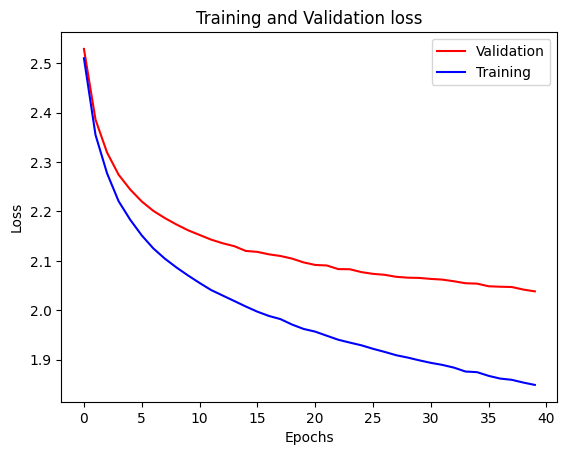

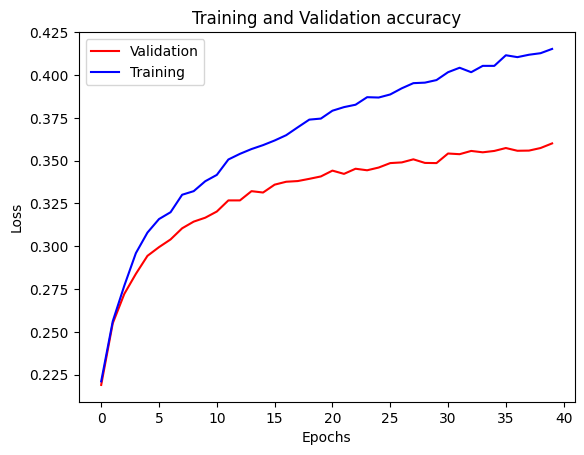

Train accuracy: 0.4153
Valid accuracy: 0.3601
Train loss: 1.8489621845576423
Valid loss: 2.0383111939305674


In [77]:
# hyperparameters
features = train.x.shape[0]
batch_size = 100
_lambda = 0
eta = 0.001
n_epochs = 40
hidden_features = [10]
np.random.seed(400)
random.seed(400)

nn1 = NN(features, hidden_features, _lambda=_lambda)
train_loss, valid_loss, train_accuracy, valid_accuracy = train_nn(nn1, train, valid, n_epochs, batch_size, eta)
plot_stats(train_loss, valid_loss, "loss")
plot_stats(train_accuracy, valid_accuracy, "accuracy")

# latest train/valid accuracy and loss
print(f"Train accuracy: {train_accuracy[-1]}")
print(f"Valid accuracy: {valid_accuracy[-1]}")
print(f"Train loss: {train_loss[-1]}")
print(f"Valid loss: {valid_loss[-1]}")

Valid loss: 1.7233053749456253: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


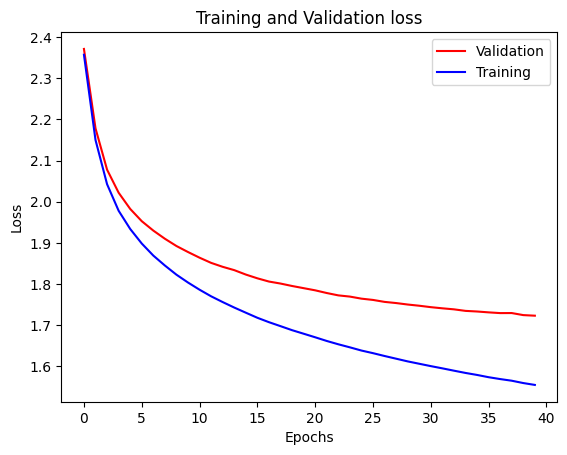

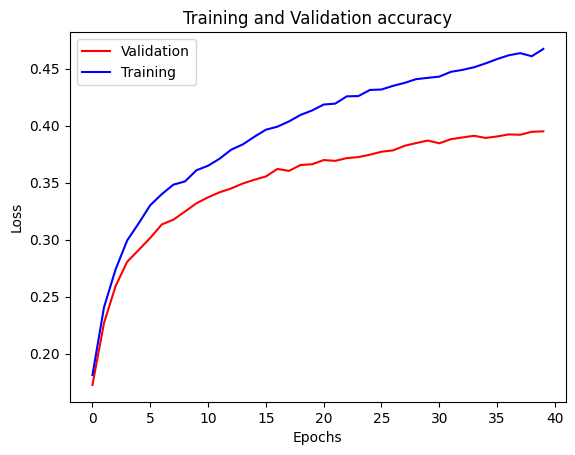

Train accuracy: 0.4674
Valid accuracy: 0.3951
Train loss: 1.555253740501216
Valid loss: 1.7233053749456253


In [78]:
# hyperparameters
features = train.x.shape[0]
batch_size = 100
_lambda = 0
eta = 0.001
n_epochs = 40
hidden_features = [50, 10]
np.random.seed(400)
random.seed(400)

nn1 = NN(features, hidden_features, _lambda=_lambda)
train_loss, valid_loss, train_accuracy, valid_accuracy = train_nn(nn1, train, valid, n_epochs, batch_size, eta)
plot_stats(train_loss, valid_loss, "loss")
plot_stats(train_accuracy, valid_accuracy, "accuracy")

# latest train/valid accuracy and loss
print(f"Train accuracy: {train_accuracy[-1]}")
print(f"Valid accuracy: {valid_accuracy[-1]}")
print(f"Train loss: {train_loss[-1]}")
print(f"Valid loss: {valid_loss[-1]}")

Valid loss: 3.1794619618481086: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


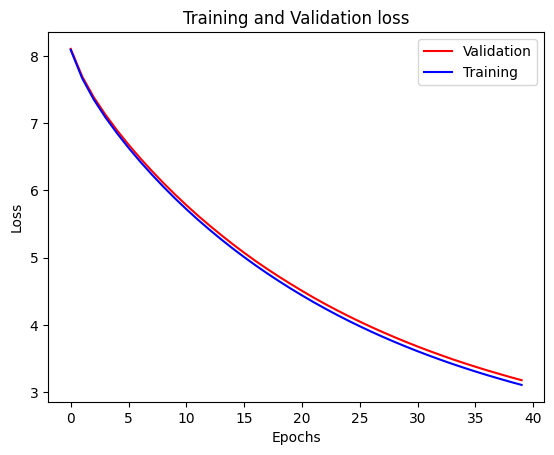

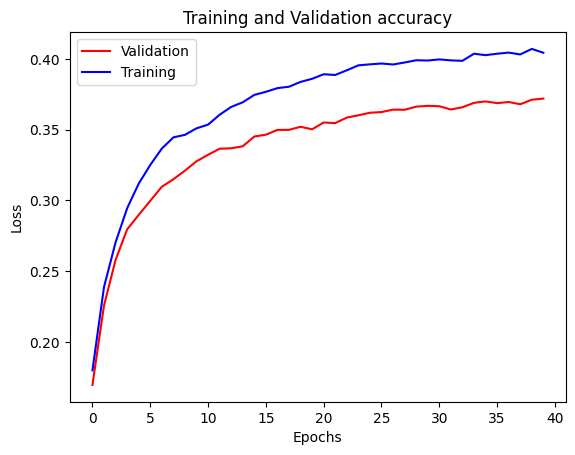

Train accuracy: 0.4043
Valid accuracy: 0.3719
Train loss: 3.109044461132868
Valid loss: 3.1794619618481086


In [80]:
# hyperparameters
features = train.x.shape[0]
batch_size = 100
_lambda = 0.1
eta = 0.001
n_epochs = 40
hidden_features = [50, 10]
np.random.seed(400)
random.seed(400)

nn1 = NN(features, hidden_features, _lambda=_lambda)
train_loss, valid_loss, train_accuracy, valid_accuracy = train_nn(nn1, train, valid, n_epochs, batch_size, eta)
plot_stats(train_loss, valid_loss, "loss")
plot_stats(train_accuracy, valid_accuracy, "accuracy")

# latest train/valid accuracy and loss
print(f"Train accuracy: {train_accuracy[-1]}")
print(f"Valid accuracy: {valid_accuracy[-1]}")
print(f"Train loss: {train_loss[-1]}")
print(f"Valid loss: {valid_loss[-1]}")

In [ ]:
# final test loss and accuracy
p = nn3(test.x)
print(f"Test loss: {nn3.cost(test.y, p)}")
print(f"Test accuracy: {nn3.compute_accuracy(test.y, p)}")

# Conclusion

So our final test accuracy is 38.67%, which is higher than randomly guessing which would have been 1/10. Given that we are only using a single layer and have no other techniques than a simple l2-norm regularization, this is not too bad. It's slightly lower than what my instructor got in my DL course around 38.83%, but that doesn't mean much as there are alot of variability and depends on the seed, I think I got 39.2% with seed 1. At least it seems consistent to be close to what they got.

With that said, this last experiment concludes this notebook. Hopefully it shows the process very clearly, aside from the extra stuff like center difference method, preprocessing the data and implementing the mini-batch GD, the actual forward and backward pass was very short. We simply followed the gradient formulas that we derived and that was it. Given that the formulas are logically correctly implemented, the harder part is implementing it without mistakes in practise, and knowing about some of the smaller details of numpy arrays and how to work with them can save you some time from making small hard to find mistakes. Anyways, we will be moving on to implementing a k-layer neural network in the next notebook.